In [1]:
import torch
import urllib
from scipy.io import wavfile
import soundfile as sf
import os
import numpy as np
from torchsummary import summary
from torch import nn, Tensor
import torch.optim as optim
from torch import hub
import csv
import sys
import time
sys.path.append('/home/maryamebr/.cache/torch/hub/harritaylor_torchvggish_master')
from torchvggish import vggish_input, vggish_params

if torch.cuda.is_available():
    device = torch.device("cuda") 
    print("Using GPUs ", device)
else:
    device = torch.device("cpu")


Using GPUs  cuda


In [2]:
model = torch.hub.load('harritaylor/torchvggish', 'vggish').to(device)

start_lr = 0.001
epochs = 200
batch_size = 16

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[180, 190], gamma=0.1)

Using cache found in /home/maryamebr/.cache/torch/hub/harritaylor_torchvggish_master


In [3]:
### reading all batches outside the loop...train set

file_name = f'audioset_datasest/trainset_mel_label_{batch_size}/'
file_list = [name for name in os.listdir(file_name)]
number_of_batches = int(len(file_list)/2)
print("number of train batches ", number_of_batches)

mel_data_train_total = []
label_data_train_total = []

for ind in range(1, number_of_batches+1):
    if (f"BS{batch_size}_mel_{ind}.pt" in file_list):
        # print(ind, end=' ')
        mel_data_batch = torch.load(f"{file_name}BS{batch_size}_mel_{ind}.pt")
        label_data_batch = torch.load(f"{file_name}BS{batch_size}_label_{ind}.pt")
        mel_data_train_total.append(mel_data_batch)
        label_data_train_total.append(label_data_batch)


####  reading all samples outside the loop...validation set
mel_data_valid_total = torch.load(f"audioset_datasest/mel_valid_total.pt")
label_data_valid_total = torch.load(f"audioset_datasest/label_valid_total.pt")
print("number of validation samples ", len(mel_data_valid_total))


number of train batches  1225
number of validation samples  17954


In [4]:
### train+validation


epoch_train_loss_list = []
epoch_valid_loss_list = []

for epoch in range(epochs):
    start_time = time.time()
    print("---------- epoch ", epoch, end=' ')
    
    #### train
    model.train(True)

    train_loss_temp = 0
    for mel_data_batch, label_data_batch in zip(mel_data_train_total, label_data_train_total):
        mel_data_batch = mel_data_batch.to(device)
        label_data_batch = label_data_batch.to(device)
        
        # clear all gradients
        optimizer.zero_grad() 

        # forward pass
        output = model.forward(mel_data_batch)

        # loss
        loss = loss_fn(output, label_data_batch)

        # compute gradients
        loss.backward()  

        # update weights/biases
        optimizer.step() 

        # store loss for each batch
        train_loss_temp += loss.data.item()
        



    ### validation
    model.train(False)
    ind = 0
    corrects_all = 0
    corrects_max = 0
    loss_valid_temp = 0
    
    for mel_data, label in zip (mel_data_valid_total, label_data_valid_total):
        # print(ind, end=' ')
        mel_data = mel_data.to(device)

        label_onehot = [1 if a in label  else 0 for a in range(527)]
        label_tensor = torch.Tensor([label_onehot for a in range(mel_data.shape[0])])
        label_tensor = label_tensor.to(device)
        # print(mel_data.shape, label_tensor.shape)

        # clear all gradients
        optimizer.zero_grad() 

        out = model(mel_data)
        pred = torch.argmax(nn.Sigmoid()(out), dim=1)
        max_pred = max(set(pred), key=list(pred).count)


        loss_valid_temp += loss_fn(out, label_tensor).data.item()
        
        corrects_all += any(x in pred for x in label)
        corrects_max += any(x in max_pred for x in label)
        ind += 1

        if ind == 100:
            break





    ### printing some stuff
    print("time:  ", time.time()-start_time , " loss: ",  train_loss_temp/number_of_batches, flush=True)    
    print("            validation loss: ", loss_valid_temp/ind, " accuracy all: ", corrects_all/ind, " accuracy max: ", corrects_max/ind, flush=True)
    
    epoch_train_loss_list.append(train_loss_temp/number_of_batches)
    epoch_valid_loss_list.append(loss_valid_temp/ind)

    # update learning rate when necessary
    scheduler.step()


torch.save(model.state_dict(),f"saved_vggish_models/vggish_state_dict_BS{batch_size}_{str(optimizer).split(' ')[0]}_lr{str(start_lr).split('.')[-1]}_epoch{epochs}.pt")
torch.save(model,f"saved_vggish_models/vggish_model_BS{batch_size}_{str(optimizer).split(' ')[0]}_lr{str(start_lr).split('.')[-1]}_epoch{epochs}.pt")

---------- epoch  0 time:   54.90083694458008  loss:  0.6048852923451637
            validation loss:  0.3925063546746969  accuracy all:  0.46  accuracy max:  0.35
---------- epoch  1 time:   52.86929249763489  loss:  0.3363156254680789
            validation loss:  0.3297991542518139  accuracy all:  0.48  accuracy max:  0.36
---------- epoch  2 time:   52.86739993095398  loss:  0.2905398962084128
            validation loss:  0.29056074358522893  accuracy all:  0.5  accuracy max:  0.29
---------- epoch  3 time:   52.9387149810791  loss:  0.2577911399943488
            validation loss:  0.2621842233091593  accuracy all:  0.5  accuracy max:  0.32
---------- epoch  4 time:   52.98351073265076  loss:  0.23249914397998733
            validation loss:  0.2394616923481226  accuracy all:  0.52  accuracy max:  0.36
---------- epoch  5 time:   53.02396297454834  loss:  0.21216731953377627
            validation loss:  0.22088423103094101  accuracy all:  0.49  accuracy max:  0.37
---------- epoc

Text(0.5, 0, 'epoch')

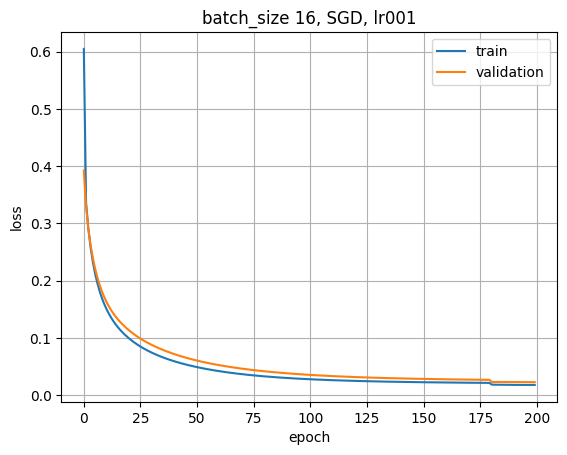

In [5]:
import matplotlib.pyplot as plt
plt.plot(epoch_train_loss_list, label='train')
plt.plot(epoch_valid_loss_list, label='validation')
plt.title(f"batch_size {batch_size}, {str(optimizer).split(' ')[0]}, lr{str(start_lr).split('.')[-1]}")
plt.grid()
plt.ylabel('loss')
plt.legend()
plt.xlabel('epoch')

In [6]:
#### full validation

model.train(False)
ind = 0
corrects_all = 0
corrects_max = 0
loss_valid_temp = 0

for mel_data, label in zip (mel_data_valid_total, label_data_valid_total):
    mel_data = mel_data.to(device)

    label_onehot = [1 if a in label  else 0 for a in range(527)]
    label_tensor = torch.Tensor([label_onehot for a in range(mel_data.shape[0])])
    label_tensor = label_tensor.to(device)

    # clear all gradients
    optimizer.zero_grad() 

    out = model(mel_data)
    pred = torch.argmax(nn.Sigmoid()(out), dim=1)
    max_pred = max(set(pred), key=list(pred).count)


    loss_valid_temp += loss_fn(out, label_tensor).data.item()
    
    corrects_all += any(x in pred for x in label)
    corrects_max += any(x in max_pred for x in label)
    ind += 1


print("validation loss: ", loss_valid_temp/ind, " accuracy all: ", corrects_all/ind, " accuracy max: ", corrects_max/ind, flush=True)

validation loss:  0.023421816682488984  accuracy all:  0.6899298206527793  accuracy max:  0.5095800378745683


In [7]:
ind

17954